## Imports

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

## Functions

In [17]:
alpha = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

In [3]:
def MinMax(foo):
    cols_n = foo.shape[1]
    for i in range(cols_n):
        v = foo[:, i]
        foo[:, i] = (v - v.min()) / (v.max() - v.min())
    return foo

In [4]:
def softargmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

def SoftArgMaxCrossEntropy(pred_probs, real):
    m = real.shape[0]
    prob = softargmax(pred_probs)
    with_log = -np.log(prob[range(m), real])
    loss = np.sum(with_log) / m
    prob[range(m),real] -= 1
    grad = prob/m
    return loss, grad

In [ ]:
class TransformLayer:
    def __init__(self, input_size, output_size, activation='relu'):
        all_activations = {
            'identity': lambda a: a,
            'relu': lambda a: np.maximum(0, a),
            'tanh': lambda a: (np.exp(a) - np.exp(-a)) / (np.exp(a) + np.exp(-a)),
        }
        all_activations_deriv = {
            'identity': lambda a: np.ones_like(a),
            'relu': lambda a: np.where(a <= 0, 0, a),
            'tanh': lambda a: 1 - np.power(all_activations['tanh'](a), 2),
        }
        np.random.seed(123)
        self.A = np.random.normal(loc=0.0, scale=2 / output_size,
                                        size=(input_size, output_size))
        self.b = np.zeros(output_size)
        self.activation = all_activations[activation]
        self.activation_deriv = all_activations_deriv[activation]

        self.mA = np.zeros_like(self.A)
        self.vA = np.zeros_like(self.A)
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        self.t = 1

    def forward(self, X):
        return self.activation(np.dot(X, self.A) + self.b)

    def backward_grad(self, X, dY):
        dX = np.dot(dY, self.A.T)
        dA = np.dot(X.T, dY)
        dB = dY.mean(axis=0) * X.shape[0]
        activation_grad = self.activation_deriv(dX)

        self.mA = beta1 * self.mA + (1.0 - beta1) * dA
        self.vA = beta2 * self.vA + (1.0 - beta2) * dA ** 2
        mA_corr = self.mA / (1.0 - beta1 ** (self.t + 1))
        vA_corr = self.vA / (1.0 - beta2 ** (self.t + 1))

        self.mb = beta1 * self.mb + (1.0 - beta1) * dB
        self.vb = beta2 * self.vb + (1.0 - beta2) * dB ** 2
        mb_corr = self.mb / (1.0 - beta1 ** (self.t + 1))
        vb_corr = self.vb / (1.0 - beta2 ** (self.t + 1))

        self.t += 1

        self.A -= alpha * mA_corr / (np.sqrt(vA_corr) + eps)
        self.b -= alpha * mb_corr / (np.sqrt(vb_corr) + eps)
        return dX * activation_grad

class RBFTransformLayer:
    def __init__(self, input_size, output_size, gamma=1.0):
        np.random.seed(123)
        self.A = np.random.normal(loc=0.0, scale=2 / output_size, size=(output_size, input_size))
        self.gamma = gamma

        self.m = np.zeros_like(self.A)
        self.v = np.zeros_like(self.A)
        self.t = 1
        self.alpha = 0.01

    def substarct(self, X):
        return X[:, np.newaxis, :] - self.A[np.newaxis, :, :]

    def distance(self, X):
        return np.sum((self.substarct(X)) ** 2, axis=2)

    def gaussian_rbf(self, X):
        return np.exp(-self.gamma * self.distance(X))

    def forward(self, X):
        return self.gaussian_rbf(X)

    def backward_grad(self, X, dY):
        dA = (2 * self.gamma * dY * self.gaussian_rbf(X))[..., np.newaxis] * self.substarct(X)
        dA = np.mean(dA, axis=0)

        self.m = beta1 * self.m + (1.0 - beta1) * dA
        self.v = beta2 * self.v + (1.0 - beta2) * dA ** 2
        m_corr = self.m / (1.0 - beta1 ** (self.t + 1))
        v_corr = self.v / (1.0 - beta2 ** (self.t + 1))
        self.t += 1
        self.A -= self.alpha * m_corr / (np.sqrt(v_corr) + eps)

        dX = -np.sum(dA, axis=0)
        return dX

In [32]:
class Sequential:
    def __init__(self, epochs=100):
        self.layers = []
        self.n_layers = 0
        self.epochs = epochs

    def add(self, layer):
        self.layers.append(layer)
        self.n_layers += 1

    def forward(self, X):
        result = []
        Xi = X

        for id in range(self.n_layers):
            Xij = self.layers[id].forward(Xi)
            result.append(Xij)
            Xi = Xij

        return result

    def fit(self, X, y):
        log = []
        for _ in range(self.epochs):
            forward_res = self.forward(X)
            layers_ans = [X] + forward_res
            back_layer = layers_ans[-1]
            init_argmax = y.argmax(axis=1)
            loss, loss_grad = SoftArgMaxCrossEntropy(back_layer, init_argmax)
            log.append(loss)

            for id in range(self.n_layers)[::-1]:
                loss_grad = self.layers[id].backward_grad(layers_ans[id], loss_grad)

        return log

    def predict(self, X_test):
        return self.forward(X_test)[-1].argmax(axis=1)

In [33]:
def plot_learning_curve(full_log):
    plt.figure(figsize=(10, 5))
    for key, value in full_log.items():
        log = value['loss']
        plt.plot(log, label=f'Loss {key} transform')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

In [9]:
def count_num_of_params(nn):
    num_of_params = 0
    for layer in nn.layers:
        num_of_params += layer.A.size + layer.b.size
    return num_of_params

In [10]:
def count_num_of_params_rdf(nn):
    num_of_params = 0
    for layer in nn.layers:
        num_of_params += layer.A.size
    return num_of_params

In [11]:
def plot_accuracy_dependOn_params(full_log):
    plt.figure(figsize=(10, 5))
    acc = []
    params = []
    for key, value in full_log.items():
        params.append(str(value['n_params']))
        acc.append(value['accuracy'])

    plt.bar(params, acc)
    plt.xlabel('N parametres')
    plt.ylabel('accuracy')
    plt.title('accuracy on N parametres')
    plt.legend()
    plt.show()

In [12]:
def plot_accuracy_dependOn_Ntransforms(full_log):
    plt.figure(figsize=(10, 5))
    acc = []
    n_layers = []
    for key, value in full_log.items():
        n_layers.append(key)
        acc.append(value['accuracy'])

    plt.bar(n_layers, acc)
    plt.xlabel('N transforms')
    plt.ylabel('accuracy')
    plt.title('accuracy on N transforms')
    plt.legend()
    plt.show()

## Dataset

In [34]:
X, y = load_breast_cancer(return_X_y=True)
X = MinMax(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_train = np.squeeze(np.eye(2)[y_train.reshape(-1)])
y_test = np.squeeze(np.eye(2)[y_test.reshape(-1)])

## Learning Matrix Transformation

In [ ]:
full_log = {}

nn = Sequential(epochs=100)
nn.add(TransformLayer(input_size=X_train.shape[1], output_size=2, activation='tanh'))

log_1 = nn.fit(X_train, y_train)
a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
full_log['1'] = {'loss': log_1, 'accuracy': a_1, 'n_params': count_num_of_params(nn)}

nn = Sequential(epochs=100)
nn.add(TransformLayer(input_size=X_train.shape[1], output_size=15, activation='relu'))
nn.add(TransformLayer(input_size=15, output_size=2, activation='relu'))

log_2 = nn.fit(X_train, y_train)
a_2 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
full_log['2'] = {'loss': log_2, 'accuracy': a_2, 'n_params': count_num_of_params(nn)}

nn = Sequential(epochs=100)
nn.add(TransformLayer(input_size=X_train.shape[1], output_size=100, activation='relu'))
nn.add(TransformLayer(input_size=100, output_size=50, activation='tanh'))
nn.add(TransformLayer(input_size=50, output_size=2, activation='relu'))

log_3 = nn.fit(X_train, y_train)
a_3 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
full_log['3'] = {'loss': log_3, 'accuracy': a_3, 'n_params': count_num_of_params(nn)}

nn = Sequential(epochs=100)
nn.add(TransformLayer(input_size=X_train.shape[1], output_size=50, activation='relu'))
nn.add(TransformLayer(input_size=50, output_size=100, activation='identity'))
nn.add(TransformLayer(input_size=100, output_size=50, activation='tanh'))
nn.add(TransformLayer(input_size=50, output_size=2, activation='identity'))

log_4 = nn.fit(X_train, y_train)
a_4 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
full_log['4'] = {'loss': log_4, 'accuracy': a_4, 'n_params': count_num_of_params(nn)}

nn = Sequential(epochs=100)
nn.add(TransformLayer(input_size=X_train.shape[1], output_size=200, activation='relu'))
nn.add(TransformLayer(input_size=200, output_size=100, activation='relu'))
nn.add(TransformLayer(input_size=100, output_size=50, activation='relu'))
nn.add(TransformLayer(input_size=50, output_size=15, activation='relu'))
nn.add(TransformLayer(input_size=15, output_size=2, activation='relu'))

log_5 = nn.fit(X_train, y_train)
a_5 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
full_log['5'] = {'loss': log_5, 'accuracy': a_5, 'n_params': count_num_of_params(nn)}

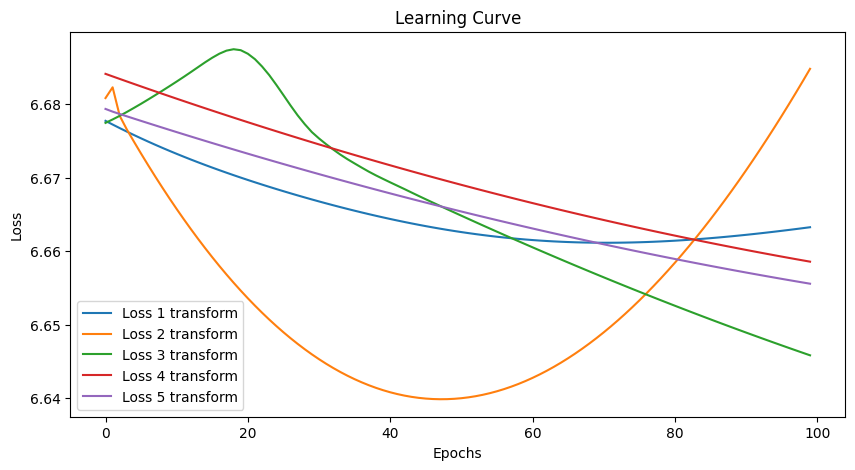

In [36]:
plot_learning_curve(full_log)

<ipython-input-11-d42152c8fb33>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


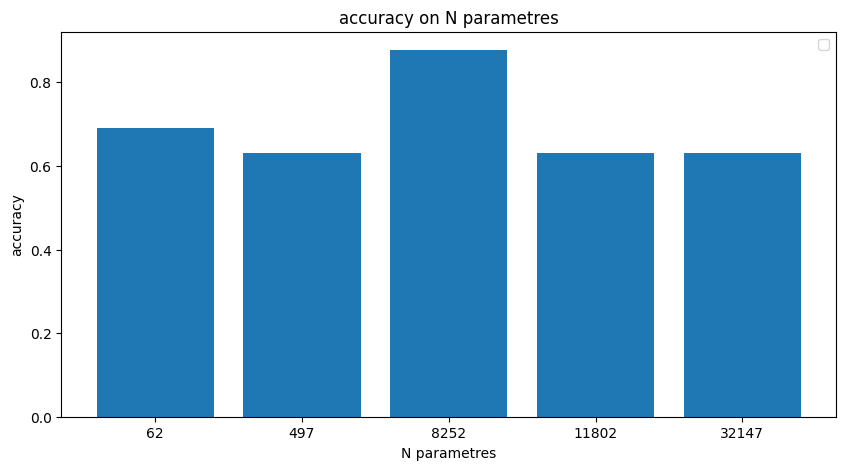

In [37]:
plot_accuracy_dependOn_params(full_log)

<ipython-input-12-fd440740363f>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


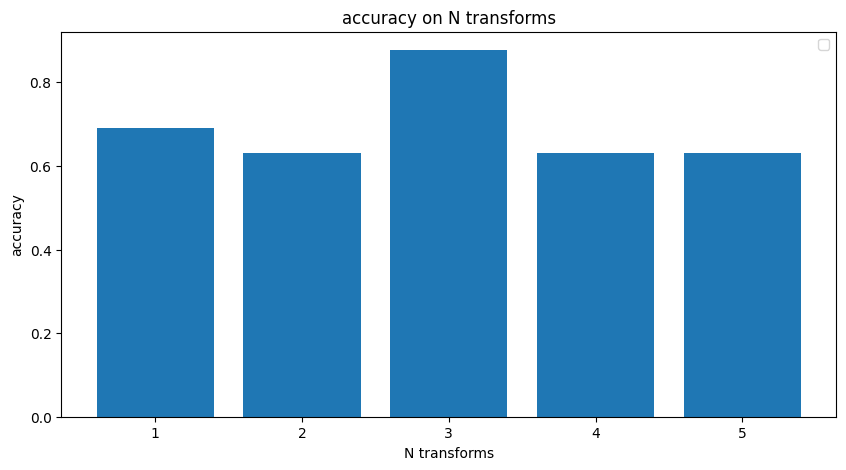

In [38]:
plot_accuracy_dependOn_Ntransforms(full_log)

## RBF Modification

In [39]:
full_log_rbf = {}

In [ ]:
best_gamma = 0.1
best_accuracy = 0.0
for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=2)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=2, gamma=i))

    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

In [ ]:
nn = Sequential(epochs=100)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=2, gamma=0.1))

log_1 = nn.fit(X_train, y_train)
a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_1)
full_log_rbf['1'] = {'loss': log_1, 'accuracy': a_1, 'n_params': count_num_of_params_rdf(nn)}

0.935672514619883


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0
for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=100)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=15, gamma=i))
    nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=i))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        best_accuracy = a_1
        best_gamma = i

print(best_gamma)
print(best_accuracy)

1.4000000000000001
0.8947368421052632


In [ ]:
nn = Sequential(epochs=100)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=15, gamma=1.4))
nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=1.4))

log_2 = nn.fit(X_train, y_train)
a_2 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_2)
full_log_rbf['2'] = {'loss': log_2, 'accuracy': a_2, 'n_params': count_num_of_params_rdf(nn)}

0.9064327485380117


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=100)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=i))
    nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=i))
    nn.add(RBFTransformLayer(input_size=30, output_size=2, gamma=i))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

0.30000000000000004
0.631578947368421


In [ ]:
nn = Sequential(epochs=100)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=0.3))
nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=0.3))
nn.add(RBFTransformLayer(input_size=30, output_size=2, gamma=0.3))

log_3 = nn.fit(X_train, y_train)
a_3 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_3)
full_log_rbf['3'] = {'loss': log_3, 'accuracy': a_3, 'n_params': count_num_of_params_rdf(nn)}

0.631578947368421


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=100)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=i))
    nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=i))
    nn.add(RBFTransformLayer(input_size=30, output_size=15, gamma=i))
    nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=i))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

0.8
0.9122807017543859


In [ ]:
nn = Sequential(epochs=100)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=0.8))
nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=0.8))
nn.add(RBFTransformLayer(input_size=30, output_size=15, gamma=0.8))
nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=0.8))

log_4 = nn.fit(X_train, y_train)
a_4 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_4)
full_log_rbf['4'] = {'loss': log_4, 'accuracy': a_4, 'n_params': count_num_of_params_rdf(nn)}

0.8771929824561403


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=100)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=100, gamma=i))
    nn.add(RBFTransformLayer(input_size=100, output_size=50, gamma=i))
    nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=i))
    nn.add(RBFTransformLayer(input_size=30, output_size=15, gamma=i))
    nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=i))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

2.4000000000000004
0.5029239766081871


In [ ]:
nn = Sequential(epochs=100)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=100, gamma=2.4))
nn.add(RBFTransformLayer(input_size=100, output_size=50, gamma=2.4))
nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=2.4))
nn.add(RBFTransformLayer(input_size=30, output_size=15, gamma=2.4))
nn.add(RBFTransformLayer(input_size=15, output_size=2, gamma=2.4))

log_5 = nn.fit(X_train, y_train)
a_5 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_5)
full_log_rbf['5'] = {'loss': log_5, 'accuracy': a_5, 'n_params': count_num_of_params_rdf(nn)}

0.631578947368421


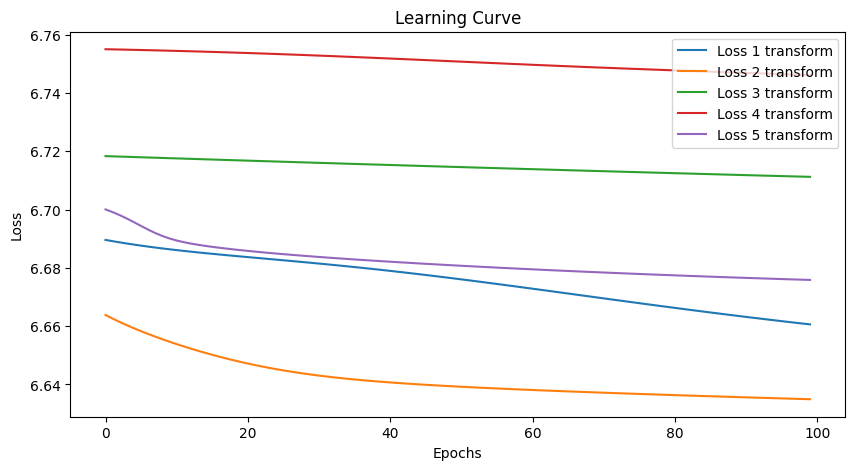

In [54]:
plot_learning_curve(full_log_rbf)

<ipython-input-11-d42152c8fb33>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


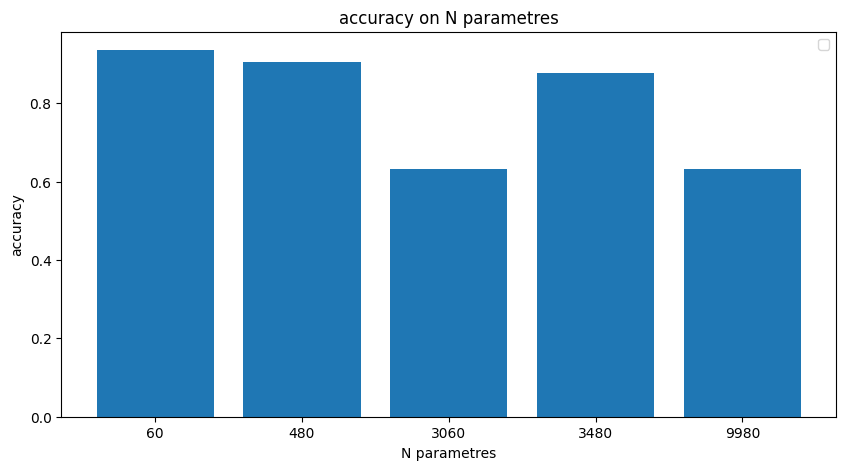

In [55]:
plot_accuracy_dependOn_params(full_log_rbf)

<ipython-input-12-fd440740363f>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


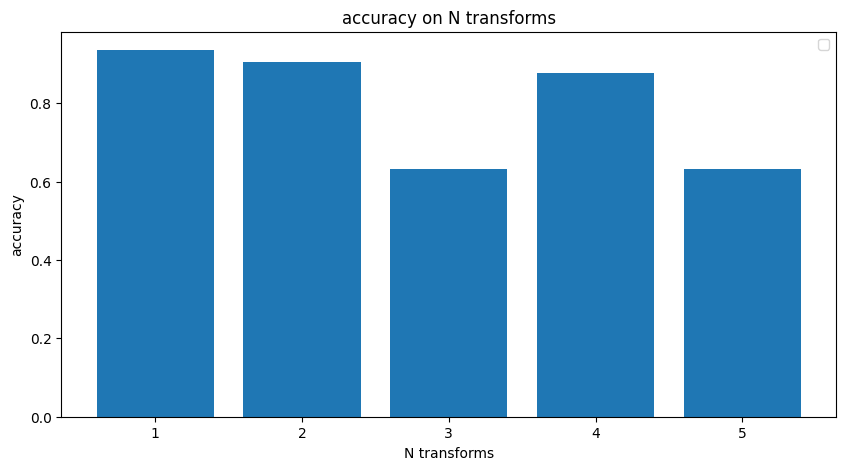

In [56]:
plot_accuracy_dependOn_Ntransforms(full_log_rbf)

## Matrix Transformation + RBF

In [ ]:
full_log_matrix_rbf = {}

In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=20)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=15, gamma=i))
    nn.add(TransformLayer(input_size=15, output_size=2, activation='relu'))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        print(best_accuracy)
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

nn = Sequential(epochs=20)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=15, gamma=best_gamma))
nn.add(TransformLayer(input_size=15, output_size=2, activation='relu'))

log_2 = nn.fit(X_train, y_train)
a_2 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_2)
full_log_matrix_rbf['rbf_1_base_1'] = {'loss': log_2, 'accuracy': a_2, 'n_params': count_num_of_params_rdf(nn)}

0.0
0.1
0.631578947368421
0.631578947368421


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=20)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=i))
    nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=i))
    nn.add(TransformLayer(input_size=30, output_size=15, activation='relu'))
    nn.add(TransformLayer(input_size=15, output_size=2, activation='identity'))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        print(best_accuracy)
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

nn = Sequential(epochs=20)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=50, gamma=best_gamma))
nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=best_gamma))
nn.add(TransformLayer(input_size=30, output_size=15, activation='relu'))
nn.add(TransformLayer(input_size=15, output_size=2, activation='identity'))

log_2 = nn.fit(X_train, y_train)
a_2 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_2)
full_log_matrix_rbf['rbf_2_base_2'] = {'loss': log_2, 'accuracy': a_2, 'n_params': count_num_of_params_rdf(nn)}

0.0
0.672514619883041
0.7134502923976608
0.8070175438596491
0.8421052631578947
0.8947368421052632
0.9005847953216374
0.7000000000000001
0.9064327485380117
0.01
0.01
0.9064327485380117


In [ ]:
best_gamma = 0.1
best_accuracy = 0.0

for i in np.arange(0.1, 5.1, 0.1):
    nn = Sequential(epochs=20)
    nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=100, gamma=i))
    nn.add(RBFTransformLayer(input_size=100, output_size=50, gamma=i))
    nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=i))
    nn.add(TransformLayer(input_size=30, output_size=15, activation='relu'))
    nn.add(TransformLayer(input_size=15, output_size=4, activation='relu'))
    nn.add(TransformLayer(input_size=4, output_size=2, activation='relu'))


    log_1 = nn.fit(X_train, y_train)
    a_1 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
    if a_1 > best_accuracy:
        print(best_accuracy)
        best_accuracy = a_1
        best_gamma = i
print(best_gamma)
print(best_accuracy)

nn = Sequential(epochs=20)
nn.add(RBFTransformLayer(input_size=X_train.shape[1], output_size=100, gamma=best_gamma))
nn.add(RBFTransformLayer(input_size=100, output_size=50, gamma=best_gamma))
nn.add(RBFTransformLayer(input_size=50, output_size=30, gamma=best_gamma))
nn.add(TransformLayer(input_size=30, output_size=15, activation='relu'))
nn.add(TransformLayer(input_size=15, output_size=4, activation='relu'))
nn.add(TransformLayer(input_size=4, output_size=2, activation='relu'))

log_2 = nn.fit(X_train, y_train)
a_2 = accuracy_score(y_test.argmax(axis=1), nn.predict(X_test))
print(a_2)
full_log_matrix_rbf['rbf_3_base_3'] = {'loss': log_2, 'accuracy': a_2, 'n_params': count_num_of_params_rdf(nn)}

0.0
0.1
0.631578947368421
0.01
0.01
0.631578947368421


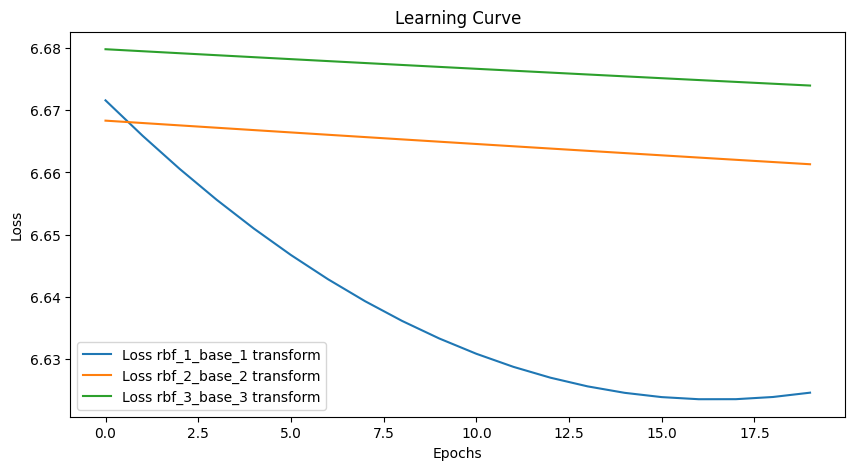

In [ ]:
plot_learning_curve(full_log_matrix_rbf)

<ipython-input-209-a17f66990389>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


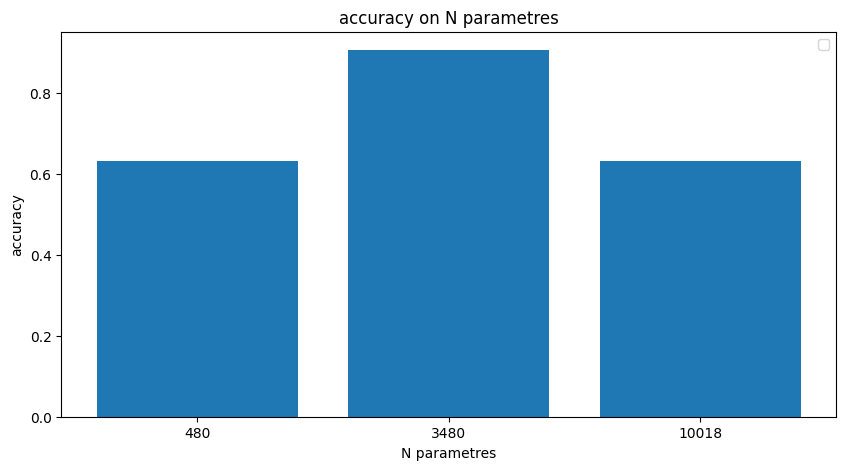

In [ ]:
plot_accuracy_dependOn_params(full_log_matrix_rbf)

<ipython-input-208-efed410df511>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


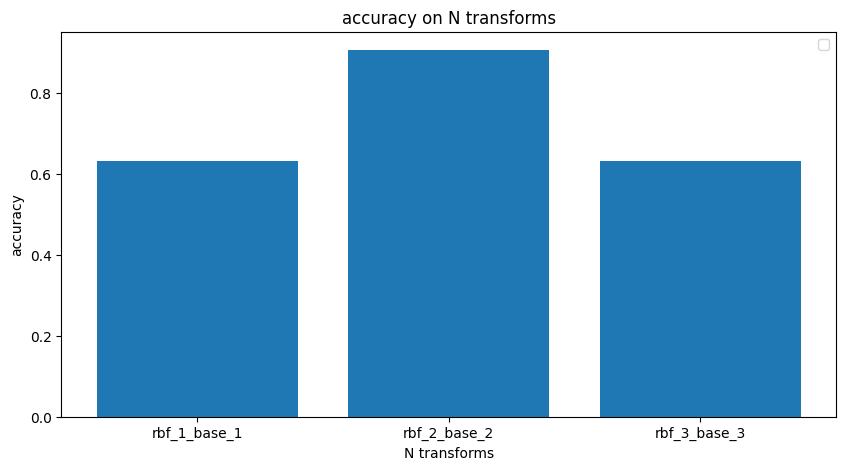

In [ ]:
plot_accuracy_dependOn_Ntransforms(full_log_matrix_rbf)